## <span style="color:DarkGreen"> *Precipitation Type Comparison between Observations & The High Resolution Ensemble Forecast (HREF)* </span>
---

<div class="alert alert-block alert-success">
<b>Notes:</b> NONE!
</div>

#### **HREF Members Used:**

###### *- Advanced Research Weather (HRW WRF-ARW)*
###### *- Finite Volume Cubed Sphere (HRW WRF-FV3)*
###### *- National Severe Storms Laboratory (HRW WRF-NSSL)*
###### *- North American Model (NAM 3km CONUS)*
###### *- High Resolution Rapid Refresh (HRRR)*

#### **Observations Used:**
###### *- New York State Mesonet (NYSM)*
###### *- Automated Surface Observing Systems (ASOS)*
###### *- Meteorological Phenomena Identification Near the Ground (mPING)*

### **Inputs**

In [1]:
# HREF Initialization Time 
year = 2022 #2022
month = 2 #2
day = 22 #22
hour = 12 #8
minute = 0 #0

# HREF Forecast Hour(s)
starthour = 11 #9
endhour = 11 #18
inc = 1

### **Imports & File Grabbing**

In [2]:
%matplotlib inline

# core
import os
import sys
import glob
import math
import cfgrib
import requests
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib as mpl

# Collections
from collections import Counter
from functools import reduce

# netCDF4
import netCDF4 as nc
from netCDF4 import Dataset

# datetime
import datetime as dt
from datetime import datetime,timedelta

#cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat 
from cartopy import feature as cfeature

# matplotlib
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import matplotlib.patheffects as PathEffects
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.dates import DateFormatter, AutoDateLocator,HourLocator,DayLocator,MonthLocator

# metpy
import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import StationPlot, USCOUNTIES
from metpy.calc import wind_speed, wind_direction, relative_humidity_from_dewpoint, wind_components

#Load in field sites
sites = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/nysm/site_locations.txt')

#Getting coordinates for mesonet data because 2022 files dont have them
fpath_coords = '/network/rit/lab/minderlab_rit/NYSM/standard/netCDF/2019/20190902.nc'

# ASOS File Grabbing 
df_NY = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/newyork.csv')
df_VT = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/vermont.csv')
df_QE = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/quebec.csv')
df_ON = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/ontario.csv')
field_dir_17= '/network/rit/lab/minderlab_rit/field_data/WINTRE_MIX_data/FZRA_data_netcdf/FZRA_20220222.nc'
field_dir_18 = '/network/rit/lab/minderlab_rit/field_data/WINTRE_MIX_data/FZRA_data_netcdf/FZRA_20220223.nc'

# NYSM File Grabbing
hour_delta = 0
minute_delta = 15
year_str = str(year)
month_str = str(month).zfill(2)
day_str = str(day)
hour_str = str(hour).zfill(2)
day2_str = str(day+1)
day3_str = str(day+2)   
base_dir = '/network/rit/lab/minderlab_rit/NYSM'
winter_dir = '/winter_products'
winter_1 = base_dir + winter_dir + '/' + year_str + month_str + day_str + '.nc'    
winter_2 = base_dir + winter_dir + '/' + year_str + month_str + day2_str + '.nc'  
winter_3 = base_dir + winter_dir + '/' + year_str + month_str + day3_str + '.nc'    
print('We are using the following paths to grab NYSM data:')
print(winter_1)
print(winter_2)
print(winter_3)
print()
NYSM_ptype = xr.open_mfdataset([winter_1,winter_2,winter_3])
ds_coords = xr.open_dataset(fpath_coords)

field_dir_17= '/network/rit/lab/minderlab_rit/field_data/WINTRE_MIX_data/FZRA_data_netcdf/FZRA_20220217.nc'
field_dir_18 = '/network/rit/lab/minderlab_rit/field_data/WINTRE_MIX_data/FZRA_data_netcdf/FZRA_20220218.nc'
ds_feb_zr = xr.open_mfdataset([field_dir_17,field_dir_18],compat='override')

####################################################################################
# HREF File Grabbing

href_base_dir = '/network/rit/lab/minderlab_rit/je845911/data/href'
yyyymmddhh_str = year_str + month_str + day_str + hour_str
yyyymmdd_str = yyyymmddhh_str[0:8]
yyyy_str = yyyymmddhh_str[0:4]
endhour = endhour +1
fhrs = np.arange(starthour,endhour,inc)
length = len(fhrs)

# ARW
arw = []
for fhr in fhrs:
    arw.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hiresw_conusarw_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')

# FV3
fv3 = []
for fhr in fhrs:
    fv3.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hiresw_conusfv3_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')

# NSSL
nssl = []
for fhr in fhrs:
    nssl.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hiresw_conusnssl_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')

# NCEP
ncep = []
for fhr in fhrs:
    ncep.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hrrr_ncep_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')

# NAM
nam = []
for fhr in fhrs:
    nam.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/nam_conusnest_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')

print("We are using the following paths to grab HREF data:")
for fpath in arw:
    print(fpath)
print()
print("We are using the following paths to grab HREF data:")
for fpath in fv3:
    print(fpath)
print()
print("We are using the following paths to grab HREF data:")
for fpath in nssl:
    print(fpath)
print()
print("We are using the following paths to grab HREF data:")
for fpath in ncep:
    print(fpath)
print()
print("We are using the following paths to grab HREF data:")
for fpath in nam:
    print(fpath)

We are using the following paths to grab NYSM data:
/network/rit/lab/minderlab_rit/NYSM/winter_products/20220222.nc
/network/rit/lab/minderlab_rit/NYSM/winter_products/20220223.nc
/network/rit/lab/minderlab_rit/NYSM/winter_products/20220224.nc

We are using the following paths to grab HREF data:
/network/rit/lab/minderlab_rit/je845911/data/href/2022/20220222/hiresw_conusarw_2022022212f011.grib2

We are using the following paths to grab HREF data:
/network/rit/lab/minderlab_rit/je845911/data/href/2022/20220222/hiresw_conusfv3_2022022212f011.grib2

We are using the following paths to grab HREF data:
/network/rit/lab/minderlab_rit/je845911/data/href/2022/20220222/hiresw_conusnssl_2022022212f011.grib2

We are using the following paths to grab HREF data:
/network/rit/lab/minderlab_rit/je845911/data/href/2022/20220222/hrrr_ncep_2022022212f011.grib2

We are using the following paths to grab HREF data:
/network/rit/lab/minderlab_rit/je845911/data/href/2022/20220222/nam_conusnest_2022022212f011

### **Managing Observational and HREF Member Data**

In [3]:
# WINTRE-MIX REGION
latN = 46.5
latS = 43.75
lonW = -77.0
lonE = -72.0
cLat = (latN + latS)/2
cLon = (lonW + lonE )/2

#NYSM FZRA
ds_coords['station']=np.array([str(stn.values,'utf-8') for stn in ds_coords['station']])

# Adding Lat and Lon from 2019 NYSM file to the 2022 FZRA Files 
ds_feb_zr = ds_feb_zr.assign(lat = ds_coords['lat'])
ds_feb_zr = ds_feb_zr.assign(lon = ds_coords['lon'])

# Converting FZRA NYSM .nc files to Pandas Dataframes
df_feb_zr = ds_feb_zr.to_dataframe()
df_feb_zr = df_feb_zr.reset_index(level=1)
df_feb_zr['datetime'] = df_feb_zr['datetime'].dt.strftime('%Y-%m-%d %H:%M')
df_meso_time_zr = df_feb_zr['datetime'].values.flatten()

# Adding Lat and Lon from 2019 NYSM file to the 2022 Files 
NYSM_ptype = NYSM_ptype.assign(lat = ds_coords['lat'])
NYSM_ptype = NYSM_ptype.assign(lon = ds_coords['lon'])

# Converting NYSM .nc files to Pandas Dataframes
NYSM_ptype = NYSM_ptype.to_dataframe()
NYSM_ptype = NYSM_ptype.reset_index(level=1)

# Dropping extra variables 
NYSM_ptype = NYSM_ptype.drop(['snow_depth_smooth','snow_depth_change_1hr',
                              'snow_depth_change_3hr','snow_depth_change_6hr',
                              'snow_depth_change_12hr','snow_depth_change_24hr',
                              'snow_accumulation_1hr','snow_accumulation_3hr',
                              'snow_accumulation_6hr','snow_accumulation_12hr',
                              'snow_accumulation_24hr','precip_1hr','precip_3hr',
                              'precip_6hr','precip_12hr','precip_24hr','frozen_prop',
                              'slr_1hr','slr_3hr','slr_6hr','slr_12hr','slr_24hr',
                              'frozen05','frozen25','frozen50'] , axis=1)

#Greating the colorbar for the ASOS observations
ptype_colors = [(1,1,1,1),'tab:blue','mediumslateblue','darkslateblue','deeppink','darkmagenta','tab:green','darkturquoise','cyan','grey']
cmap_ptype_ext = mpl.colors.ListedColormap(ptype_colors)
norm_ptype_ext = mpl.colors.BoundaryNorm([-1,0,1,2,3,5,6,8,9,10,11],ncolors = len(ptype_colors))
ptype_ticks = [-0.5,0.5,1.5,2.5,4,5.5,7,8.5,9.5,10.5,11.5]
ptype_labels = ['NP','SN','IP','IP/SN','ZR','ZR/IP','RA','RA/SN','RA/IP','UP']

cbar_ptype = mpl.cm.ScalarMappable(norm = norm_ptype_ext, cmap = cmap_ptype_ext)
cbar_ptype.set_array([])


# Replacing #'s and letters w/ variables from the ptype map defined above
NYSM_ptype['ptype_snow'] = NYSM_ptype['ptype_snow'].replace([0],['NULL'])
NYSM_ptype['ptype_rain'] = NYSM_ptype['ptype_rain'].replace([0],['NULL'])
NYSM_ptype['ptype_freezing_rain'] = NYSM_ptype['ptype_freezing_rain'].replace([0],['NULL'])
NYSM_ptype['ptype_unknown'] = NYSM_ptype['ptype_unknown'].replace([0],['NULL'])

NYSM_ptype['ptype_freezing_rain'] = NYSM_ptype['ptype_freezing_rain'].replace(['NULL',1],[-0.1,3.99])
NYSM_ptype['ptype_unknown'] = NYSM_ptype['ptype_unknown'].replace(['NULL',1.0],[-0.1,10.99])
NYSM_ptype['ptype_rain'] = NYSM_ptype['ptype_rain'].replace(['NULL',1],[-0.1,7.99])
NYSM_ptype['ptype_snow'] = NYSM_ptype['ptype_snow'].replace(['NULL',1],[-0.1,0.99])

#NYSM_ptype2 = NYSM_ptype[NYSM_ptype['ptype_unknown'] != 0] #uncomment out if you just want to see times where it was precipitating
NYSM_ptype2 = NYSM_ptype.dropna() #dropping NaN

# Adding together #'s we mapped for ptype into one column.
NYSM_ptype2['ptype'] = NYSM_ptype2['ptype_rain'].astype(float)+NYSM_ptype2['ptype_snow'].astype(float)+NYSM_ptype2['ptype_freezing_rain'].astype(float)+NYSM_ptype2['ptype_unknown'].astype(float)

# Cropping Data
NYSM_ptype_cropped = NYSM_ptype2[
    (NYSM_ptype2["lat"] <= latN) & 
    (NYSM_ptype2["lat"] >= latS) & 
    (NYSM_ptype2["lon"] >= lonW) & 
    (NYSM_ptype2["lon"] <= lonE)
]

valid_time = datetime(year,month,day,hour,minute)
valid_time_str = valid_time.strftime("%Y-%m-%d %H:%M") 
hr = valid_time+dt.timedelta(minutes=minute_delta)
time = hr.strftime("%Y-%m-%d %H:%M")

# mPING

#**********
#Setup variables
var_name = 'mping' #used in plot filename

api_key = '96edae02d51f0bf079e7fee0974837c3908f9e9e'

interval_min = 60 #60
interval_minstr = str(interval_min)
#**********

imgdir = f'images/{var_name}/' #location to save images
if not os.path.exists(imgdir):
    os.makedirs(imgdir)
imgdir = '' #uncomment to save in current directory

def get_mping_obs(adjtime, interval_min = interval_min, time_window = 'center'):
    '''Retrieve mPING observations and parse into a pandas DataFrame
    Inputs: 
        adjtime (datetime object) - desired observation time
        interval_min (int) - range of time in minutes to get observations  
        time_window ("begin", "center" or "end") 
            - "begin": get obs for interval_min beginning at adjtime
            - "center": get obs centered on adjtime
            - "end": get obs for interval_min ending at adjtime
    Return:
        pandas DataFrame with nicely parsed obs'''
    
    reqheaders = {
    'content-type': 'application/json',
    'Authorization': f'Token {api_key}',
    }
    
    #Form API query URL
    mping_url_base = 'http://mping.ou.edu/mping/api/v2/reports'
    
    #Add filters to base URL
    if time_window == 'begin':
        #get all reports for time interval beginning at valid time
        mping_start = adjtime
        mping_end = adjtime + timedelta(minutes = interval_min)
        mping_url = f'{mping_url_base}?obtime_gte={mping_start:%Y-%m-%d %H:%M:%S}&obtime_lt={mping_end:%Y-%m-%d %H:%M:%S}'
        #print (mping_url)
    elif time_window == 'end':
        #get all reports for 1h preceding valid time
        #mping_valid = adjtime - timedelta(minutes = interval_min)
        #mping_url = f'{mping_url_base}?year={mping_valid:%Y}&month={mping_valid:%-m}&day={mping_valid:%-d}&hour={mping_valid:%-H}'
        #get all reports for time interval ending at valid time
        mping_start = adjtime - timedelta(minutes = interval_min)
        mping_end = adjtime
        mping_url = f'{mping_url_base}?obtime_gt={mping_start:%Y-%m-%d %H:%M:%S}&obtime_lte={mping_end:%Y-%m-%d %H:%M:%S}'
        #print (mping_url)
    elif time_window == 'center':
        #get all reports for time interval centered on valid time
        mping_start = adjtime - timedelta(minutes = interval_min//2)
        mping_end = adjtime + timedelta(minutes = interval_min//2)
        mping_url = f'{mping_url_base}?obtime_gte={mping_start:%Y-%m-%d %H:%M:%S}&obtime_lt={mping_end:%Y-%m-%d %H:%M:%S}'
        #print (mping_url)
     
    #Retrieve JSON data
    response = requests.get(mping_url, headers = reqheaders)
    if response.status_code != 200:
        print (f'request failed with status code {response.status_code}')
        return
    else:
        data = response.json()
        print (f'mPING Valid: {adjtime:%Y-%m-%d %H:%M} UTC (Retrieved {data["count"]} Reports over the past {interval_minstr} minutes)')
    
    #Read mPING json into dataframe for easier filtering
    df = pd.DataFrame.from_dict(data['results'])
    #Parse out lat/lon data
    df['longitude'] = [geom['coordinates'][0] for geom in df['geom']]
    df['latitude'] = [geom['coordinates'][1] for geom in df['geom']]
    
    #could stop here
    #return df
    
    #Also map mPING p-types to p-type values/colors used in colorbar
    mping_types_map_m = {'NULL': 0,
                      'Snow and/or Graupel': 1,
                      'Ice Pellets/Sleet': 2,
                      'Mixed Ice Pellets and Snow': 3,
                      'Freezing Rain': 4,
                      'Freezing Drizzle': 4, #don't have separate category for this currently
                      'Mixed Freezing Rain and Ice Pellets': 6,
                      'Rain': 8, 
                      'Drizzle': 8, #don't have separate category for this
                      'Mixed Rain and Snow': 9,
                      'Mixed Rain and Ice Pellets': 10,
                      }
    #map indexes to colors (optional: only works if continuous value HRRRE colorbar used)
    #mping_colors_map = {k:ptype_colors[int(v)] for k,v in mping_types_map.items()}
    
    #Subtract 0.01 to make p-type categories correct
    df['ptype'] = df['description'].map(mping_types_map_m) - 0.01
    #df['ptype_colors'] = df['description'].map(mping_colors_map)
    
    return df

# ASOS

dfs = [df_NY, df_ON, df_QE, df_VT] #Combining the ASOS dataframes from selected stations in Ontario, Quebec, and NY
df_merged = pd.concat(dfs)

#defining the map for what we are going to map the precip types (#'s) to
precip_types_map = {'NULL': -0.1,
                      'Snow and/or Graupel': 0.99,
                      'Ice Pellets/Sleet': 1.99,
                      'Mixed Ice Pellets and Snow': 2.99,
                      'Freezing Rain': 3.99,
                      'Freezing Drizzle': 3.99, #don't have separate category for this currently
                      'Mixed Freezing Rain and Ice Pellets': 5.99,
                      'Rain': 7.99, 
                      'Drizzle': 7.99, #don't have separate category for this
                      'Mixed Rain and Snow': 8.99,
                      'Mixed Rain and Ice Pellets': 9.99,
                      'Unknown Precip': 10.99
                      }

#Replacing all of the metar codes with the easier to read map language, this is also used to coencide with the MPING data better as we will use the same language between both
df_merged['wxcodes'] = df_merged['wxcodes'].replace(['NP','M','NaN','DRSN', 'BR','FG', 'HZ', 'FZFG'],
                                                   ['NULL','NULL','NULL', 'NULL', 'NULL','NULL', 'NULL','NULL'])
    
df_merged['wxcodes'] = df_merged['wxcodes'].replace(['NULL','-SN','-SN BR','SN','-SN DRSN','-SNBR','+SN','SN FZFG'],
                                                     ['NULL','Snow and/or Graupel','Snow and/or Graupel','Snow and/or Graupel','Snow and/or Graupel','Snow and/or Graupel', 'Snow and/or Graupel','Snow and/or Graupel'])

df_merged['wxcodes'] = df_merged['wxcodes'].replace(['-IP','IP','+IP'],['Ice Pellets/Sleet','Ice Pellets/Sleet','Ice Pellets/Sleet']) 

df_merged['wxcodes'] = df_merged['wxcodes'].replace(['-RA','RA','+RA','RA BR','-RA FG','-DZ BR','-DZ FG','DZ BR','-RA BR','DZ FG','RA FG','-SHGS','+RA BR','VCSH'],
                                                    ['Rain','Rain','Rain','Rain','Rain','Rain','Rain','Rain','Rain','Rain','Rain','Rain','Rain','Rain']) 

df_merged['wxcodes'] = df_merged['wxcodes'].replace(['FZDZ FZFG','FZRA FG','FZRA','-FZDZ','-FZDZ BR','-FZRA','+FZRA','-FZRA BR','FZDZ','FZRA BR'],
                                                    ['Freezing Rain','Freezing Rain','Freezing Rain','Freezing Rain','Freezing Rain','Freezing Rain','Freezing Rain','Freezing Rain','Freezing Rain','Freezing Rain'])

df_merged['wxcodes'] = df_merged['wxcodes'].replace(['-FZRA -PL','-FZRAPL BR','-FZRA -PL DRSN'],['Mixed Freezing Rain and Ice Pellets','Mixed Freezing Rain and Ice Pellets','Mixed Freezing Rain and Ice Pellets'])

df_merged['wxcodes'] = df_merged['wxcodes'].replace(['-SHSN','-FZRA -SN DRSN'],['Mixed Rain and Snow','Mixed Rain and Snow']) 

df_merged['wxcodes'] = df_merged['wxcodes'].replace(['-SNPL DRSN', '-PLSN DRSN'],['Mixed Ice Pellets and Snow','Mixed Ice Pellets and Snow']) 

df_merged['wxcodes'] = df_merged['wxcodes'].replace(['UP','-UP'],['Unknown Precip','Unknown Precip']) 

    
df_merged['ptype'] = df_merged['wxcodes'].map(precip_types_map) 

df_merged_cropped = df_merged[
    (df_merged["lat"] <= latN) & 
    (df_merged["lat"] >= latS) & 
    (df_merged["lon"] >= lonW) & 
    (df_merged["lon"] <= lonE)
]

# HREF

# Snow Colorbar
ptype_colors_snow = [(1,1,1), 'tab:blue']
cmap_ptype_ext_snow = mpl.colors.ListedColormap(ptype_colors_snow)
my_cmap = cmap_ptype_ext_snow(np.arange(cmap_ptype_ext_snow.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap_ptype_ext_snow.N)
my_cmap_snow = ListedColormap(my_cmap)

# Ice Colorbar
ptype_colors_icep = [(1,1,1), 'mediumslateblue']
cmap_ptype_ext_icep = mpl.colors.ListedColormap(ptype_colors_icep)
my_cmap = cmap_ptype_ext_icep(np.arange(cmap_ptype_ext_icep.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap_ptype_ext_icep.N)
my_cmap_icep = ListedColormap(my_cmap)

# Ice / Snow Colorbar
ptype_colors_snow_icep = [(1,1,1), 'darkslateblue']
cmap_ptype_ext_snow_icep = mpl.colors.ListedColormap(ptype_colors_snow_icep)
my_cmap = cmap_ptype_ext_snow_icep(np.arange(cmap_ptype_ext_snow_icep.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap_ptype_ext_snow_icep.N)
my_cmap_icep_snow = ListedColormap(my_cmap)

# Freezing Rain Colorbar
ptype_colors_fzra = [(1,1,1), 'deeppink']
cmap_ptype_ext_fzra = mpl.colors.ListedColormap(ptype_colors_fzra)
my_cmap = cmap_ptype_ext_fzra(np.arange(cmap_ptype_ext_fzra.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap_ptype_ext_fzra.N)
my_cmap_fzra = ListedColormap(my_cmap)

# Freezing Rain / Ice Colorbar
ptype_colors_fzra_icep = [(1,1,1), 'darkmagenta']
cmap_ptype_ext_fzra_icep = mpl.colors.ListedColormap(ptype_colors_fzra_icep)
my_cmap = cmap_ptype_ext_fzra_icep(np.arange(cmap_ptype_ext_fzra_icep.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap_ptype_ext_fzra_icep.N)
my_cmap_fzra_icep = ListedColormap(my_cmap)

# Rain Colorbar
ptype_colors_rain = [(1,1,1), 'tab:green']
cmap_ptype_ext_rain = mpl.colors.ListedColormap(ptype_colors_rain)
my_cmap = cmap_ptype_ext_rain(np.arange(cmap_ptype_ext_rain.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap_ptype_ext_rain.N)
my_cmap_rain = ListedColormap(my_cmap)

# Rain / Ice
ptype_colors_rain_icep = [(1,1,1), 'cyan']
cmap_ptype_ext_rain_icep = mpl.colors.ListedColormap(ptype_colors_rain_icep)
my_cmap = cmap_ptype_ext_rain_icep(np.arange(cmap_ptype_ext_rain_icep.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap_ptype_ext_rain_icep.N)
my_cmap_rain_icep = ListedColormap(my_cmap)

#Rain / Snow
ptype_colors_rain_snow= [(1,1,1),'darkturquoise']
cmap_ptype_ext_rain_snow = mpl.colors.ListedColormap(ptype_colors_rain_snow)
my_cmap = cmap_ptype_ext_rain_snow(np.arange(cmap_ptype_ext_rain_snow.N))
my_cmap[:,-1] = np.linspace(0,1, cmap_ptype_ext_rain_snow.N)
my_cmap_rain_snow = ListedColormap(my_cmap)
norm_ptype = mpl.colors.BoundaryNorm([0,1.1,2.1],ncolors = len(ptype_colors_rain_snow));

/tmp/ipykernel_31059/2134567154.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NYSM_ptype2['ptype'] = NYSM_ptype2['ptype_rain'].astype(float)+NYSM_ptype2['ptype_snow'].astype(float)+NYSM_ptype2['ptype_freezing_rain'].astype(float)+NYSM_ptype2['ptype_unknown'].astype(float)


### **5 Pannel Output**

Loading In Observational Data...
mPING Valid: 2022-02-22 23:00 UTC (Retrieved 159 Reports over the past 60 minutes)
ASOS Valid: 2022-02-22 23:00 UTC
NYSM Valid: 2022-02-22 23:00 UTC

Loading In HREF Data...
ARW Valid: 2022-02-22 23:00 UTC
FV3 Valid: 2022-02-22 23:00 UTC
NSSL Valid: 2022-02-22 23:00 UTC
NCEP Valid: 2022-02-22 23:00 UTC
NAM Valid: 2022-02-22 23:00 UTC



/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries i

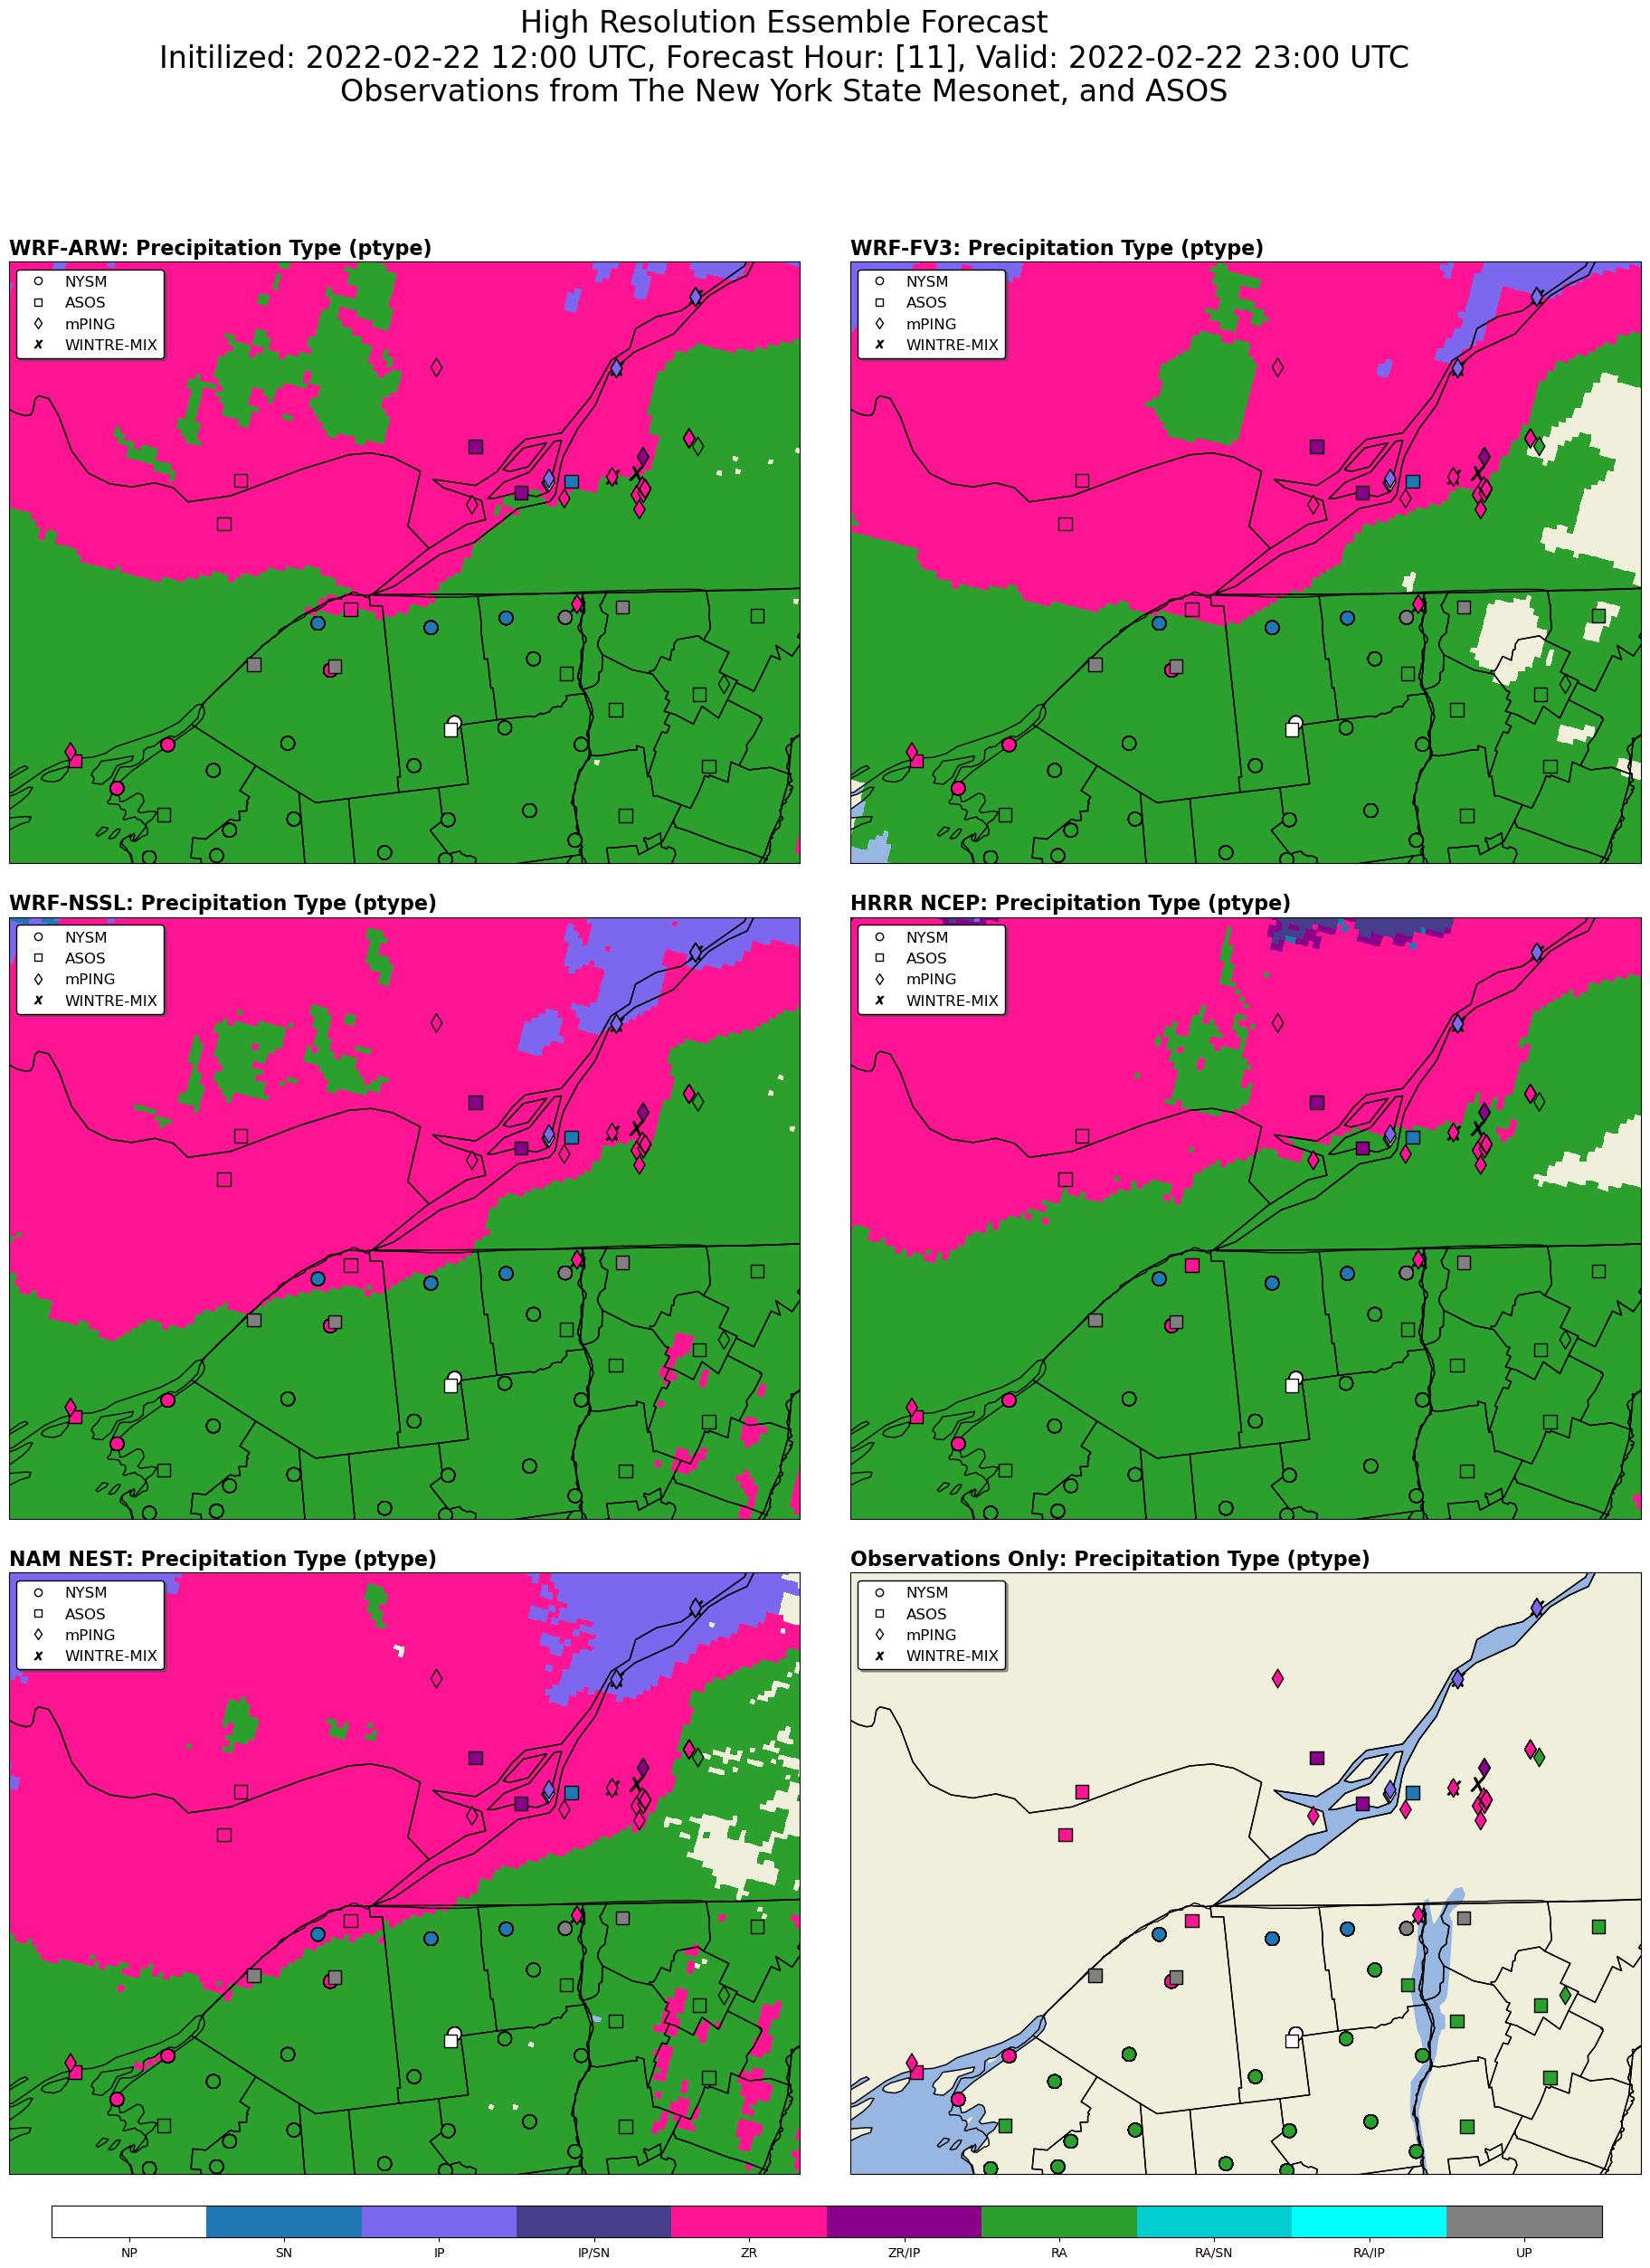

In [4]:
for i in fhrs:

    # Time 
    D = int(((i-starthour)/inc)) # Used for HREF File Reference  
    time = (hr) + timedelta(hours=float(i)) 
    adjtime = time - dt.timedelta(minutes=minute_delta)
    adjtimestr = adjtime.strftime("%Y-%m-%d %H:%M") 
    nysm_adjtime = time.strftime("%H:%M")
    time_delta = (hr) - timedelta(hours=hour_delta, minutes=minute_delta)
    time_delta_str = time_delta.strftime("%Y-%m-%d %H:%M") 
    titlestrend = adjtime.strftime("%Y-%m-%d %H:%M")

# Observational Data

    print("Loading In Observational Data...")
    
    # MPING
    df = get_mping_obs(adjtime, interval_min = interval_min, time_window = 'end')
    
    # ASOS
    mask_ASOS = (df_merged_cropped['valid'] > time_delta_str) & (df_merged_cropped['valid'] <= adjtimestr)
    ASOS_cropped = df_merged_cropped.loc[mask_ASOS]
    df_merged = ASOS_cropped.drop_duplicates(subset='station', keep='last', inplace=False)
    df_merged = df_merged.dropna()
    lats_ASOS_ptype = df_merged['lat']
    lons_ASOS_ptype = df_merged['lon']
    ptype_ASOS = df_merged['ptype']
    print("ASOS Valid: " + adjtimestr + ' UTC')
    
    # NYSM
    mask_NYSM = (NYSM_ptype_cropped['time_5M'] > time_delta_str) & (NYSM_ptype_cropped['time_5M'] <= adjtimestr)
    NYSM_ptype_mask = NYSM_ptype_cropped.loc[mask_NYSM]
    NYSM_ptype_lat = NYSM_ptype_mask['lat']
    NYSM_ptype_lon = NYSM_ptype_mask['lon']
    NYSM_ptype = NYSM_ptype_mask['ptype'].astype(float)
    print('NYSM Valid: '+ adjtimestr + ' UTC')
    print()
    
    # FZRA
    mask_NYSM_zr =  (df_feb_zr["datetime"] > time_delta_str) & (df_feb_zr["datetime"] <= adjtimestr) 
    df_feb_zr_mask = df_feb_zr.loc[mask_NYSM_zr]
    
    NYSM_zr = df_feb_zr_mask
    NYSM_zr = NYSM_zr.groupby(["station",'lat','lon'], as_index=False).agg(ice_sum=("Daily_accum_ice_inc_mm", "sum"))
    NYSM_zr = NYSM_zr[NYSM_zr['ice_sum'] != 0] #uncomment out if you just want to see times where it was precipitating

    lats_NYSM_zr = NYSM_zr['lat']
    lons_NYSM_zr = NYSM_zr['lon']
    NYSM_zr = NYSM_zr['ice_sum']
      
# HREF 

    print("Loading In HREF Data...")
    
    # ARW RA
    with xr.open_mfdataset(arw[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260029}) as arw_cr:
        arw_rain = arw_cr['crain']
        arw_crain = arw_rain.squeeze()
        arw_cr.close()
        arw_rain.close()
        
    #ARW FZRA
    with xr.open_mfdataset(arw[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260030}) as arw_cf:
        arw_fzra = arw_cf['cfrzr']
        arw_cfzra = arw_fzra.squeeze()
        arw_cf.close()
        arw_fzra.close()

    # ARW PL
    with xr.open_mfdataset(arw[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260031}) as arw_ip:
        arw_icep = arw_ip['cicep']
        arw_cicep = arw_icep.squeeze()
        arw_ip.close()
        arw_icep.close()

    # ARW SN
    with xr.open_mfdataset(arw[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260032}) as arw_sn:
        arw_snow = arw_sn['csnow']
        print('ARW Valid: '+ adjtimestr + ' UTC')
        arw_csnow = arw_snow.squeeze()
        arw_sn.close()
        arw_snow.close()
              
    # FV3 RA
    with xr.open_mfdataset(fv3[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260029}) as fv3_cr:
        fv3_rain = fv3_cr['crain']
        fv3_crain = fv3_rain.squeeze()
        fv3_cr.close()
        fv3_rain.close()

    # FV3 FZRA
    with xr.open_mfdataset(fv3[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260030}) as fv3_cf:
        fv3_fzra = fv3_cf['cfrzr']
        fv3_cfzra = fv3_fzra.squeeze()
        fv3_cf.close()
        fv3_fzra.close()

    # FV3 PL
    with xr.open_mfdataset(fv3[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260031}) as fv3_ip:
        fv3_icep = fv3_ip['cicep']
        fv3_cicep = fv3_icep.squeeze()
        fv3_ip.close()
        fv3_icep.close()

    # FV3 SN
    with xr.open_mfdataset(fv3[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260032}) as fv3_sn:
        fv3_snow = fv3_sn['csnow']
        print('FV3 Valid: '+ adjtimestr + ' UTC')
        fv3_csnow = fv3_snow.squeeze()
        fv3_sn.close()
        fv3_snow.close()
           
    # NSSL RA
    with xr.open_mfdataset(nssl[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260029}) as nssl_cr:
        nssl_rain = nssl_cr['crain']
        nssl_crain = nssl_rain.squeeze()
        nssl_cr.close()
        nssl_rain.close()

    # NSSL FZRA
    with xr.open_mfdataset(nssl[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260030}) as nssl_cf:
        nssl_fzra = nssl_cf['cfrzr']
        nssl_cfzra = nssl_fzra.squeeze()
        nssl_cf.close()
        nssl_fzra.close()

    # NSSL PL
    with xr.open_mfdataset(nssl[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260031}) as nssl_ip:
        nssl_icep = nssl_ip['cicep']
        nssl_cicep = nssl_icep.squeeze()
        nssl_ip.close()
        nssl_icep.close()

    # NSSL SN
    with xr.open_mfdataset(nssl[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260032}) as nssl_sn:
        nssl_snow = nssl_sn['csnow']
        print('NSSL Valid: '+ adjtimestr + ' UTC')
        nssl_csnow = nssl_snow.squeeze()
        nssl_sn.close()
        nssl_snow.close()
         
    # NCEP RA
    with xr.open_mfdataset(ncep[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260029}) as ncep_cr:
        ncep_rain = ncep_cr['crain']
        ncep_crain = ncep_rain.squeeze()
        ncep_cr.close()
        ncep_rain.close()

    # NCEP FZRA
    with xr.open_mfdataset(ncep[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260030}) as ncep_cf:
        ncep_fzra = ncep_cf['cfrzr']
        ncep_cfzra = ncep_fzra.squeeze()
        ncep_cf.close()
        ncep_fzra.close()

    # NCEP PL
    with xr.open_mfdataset(ncep[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260031}) as ncep_ip:
        ncep_icep = ncep_ip['cicep']
        ncep_cicep = ncep_icep.squeeze()
        ncep_ip.close()
        ncep_icep.close()

    # NCEP SN
    with xr.open_mfdataset(ncep[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260032}) as ncep_sn:
        ncep_snow = ncep_sn['csnow']
        print('NCEP Valid: '+ adjtimestr + ' UTC')
        ncep_csnow = ncep_snow.squeeze()
        ncep_sn.close()
        ncep_snow.close()
         
    # NAM RA
    with xr.open_mfdataset(nam[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260029}) as nam_cr:
        nam_rain = nam_cr['crain']
        nam_crain = nam_rain.squeeze()
        nam_cr.close()
        nam_rain.close()

    # NAM FZRA
    with xr.open_mfdataset(nam[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260030}) as nam_cf:
        nam_fzra = nam_cf['cfrzr']
        nam_cfzra = nam_fzra.squeeze()
        nam_cf.close()
        nam_fzra.close()

    # NAM PL
    with xr.open_mfdataset(nam[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260031}) as nam_ip:
        nam_icep = nam_ip['cicep']
        nam_cicep = nam_icep.squeeze()
        nam_ip.close()
        nam_icep.close()

    # NAM SN
    with xr.open_mfdataset(nam[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260032}) as nam_sn:
        nam_snow = nam_sn['csnow']
        print('NAM Valid: '+ adjtimestr + ' UTC')
        nam_csnow = nam_snow.squeeze()
        nam_sn.close()
        nam_snow.close()
        print()
     
    # Deriving Precipitation Type from combinations of HREF catagorical precip
    
    arw_icep_fzra = np.add(arw_cicep,arw_cfzra)
    arw_icep_snow = np.add(arw_cicep,arw_csnow)
    arw_rain_snow = np.add(arw_crain,arw_csnow)
    arw_rain_icep = np.add(arw_crain,arw_cicep)
    fv3_icep_fzra = np.add(fv3_cicep,fv3_cfzra)
    fv3_icep_snow = np.add(fv3_cicep,fv3_csnow)
    fv3_rain_snow = np.add(fv3_crain,fv3_csnow)
    fv3_rain_icep = np.add(fv3_crain,fv3_cicep)
    nssl_icep_fzra = np.add(nssl_cicep,nssl_cfzra)
    nssl_icep_snow = np.add(nssl_cicep,nssl_csnow)
    nssl_rain_snow = np.add(nssl_crain,nssl_csnow)
    nssl_rain_icep = np.add(nssl_crain,nssl_cicep)
    ncep_icep_fzra = np.add(ncep_cicep,ncep_cfzra)
    ncep_icep_snow = np.add(ncep_cicep,ncep_csnow)
    ncep_rain_snow = np.add(ncep_crain,ncep_csnow)
    ncep_rain_icep = np.add(ncep_crain,ncep_cicep)
    nam_icep_fzra = np.add(nam_cicep,nam_cfzra)
    nam_icep_snow = np.add(nam_cicep,nam_csnow)
    nam_rain_snow = np.add(nam_crain,nam_csnow)
    nam_rain_icep = np.add(nam_crain,nam_cicep)

    # Defining a random variable to make a Latitude and Longitude we can use for plotting HREF members and their catagories
    lats = arw_rain['latitude']
    lons = arw_rain['longitude']
    
    # Defining Basic Plot Features
    def features(ax):
        ax.set_extent ([lonW,lonE,latS,latN]) # Cartopy Land
        norm = mpl.colors.Normalize(-10, 100)
        ax.add_feature (cfeature.LAND.with_scale(res), zorder=1) # Cartopy Land
        ax.add_feature (cfeature.OCEAN.with_scale(res), zorder=1) # Cartopy Ocean
        ax.add_feature (cfeature.LAKES.with_scale(res), zorder=1) # Cartopy Lakes
        ax.add_feature (cfeature.COASTLINE.with_scale(res), zorder = 3) # Cartopy Coastline
        ax.add_feature (cfeature.STATES.with_scale(res), zorder = 3) # Cartopy US State Boundaries
        ax.add_feature(USCOUNTIES.with_scale(county_scale),zorder= 3, linewidth = county_lw) # Cartopy US County Boundaries
        ax.scatter(sites['lon'], sites['lat'], s = msize, c = 'black', marker = "$X$" , transform = ccrs.PlateCarree(), zorder = 4, label= 'WINTRE-MIX Sites') # Plotting WINTRE-MIX Sites
        ax.scatter(NYSM_ptype_lon, NYSM_ptype_lat, s = msize, c = NYSM_ptype, cmap = cmap_ptype_ext,norm = norm_ptype_ext, transform = ccrs.PlateCarree(), zorder = 4, label='NYSM', edgecolor=color) # Plotting NYSM Sites and Data
        ax.scatter(df['longitude'], df['latitude'], s = msize, c = df['ptype'], cmap = cmap_ptype_ext, norm = norm_ptype_ext, transform = ccrs.PlateCarree(), zorder = 6, label='MPING', marker='d', edgecolor=color) # Plotting mPING Reports
        ax.scatter(lons_ASOS_ptype, lats_ASOS_ptype, s = msize, c = ptype_ASOS, cmap = cmap_ptype_ext, norm = norm_ptype_ext, transform = ccrs.PlateCarree(), zorder = 4, marker='s', label='ASOS', edgecolor=color) # Plotting ASOS Sites and Data
        ax.scatter(lons_NYSM_zr, lats_NYSM_zr, s = msize+.05, c = NYSM_zr, cmap = my_cmap_fzra, norm=norm,transform = ccrs.PlateCarree(), zorder = 5, edgecolor=color)
        ASOS = mlines.Line2D([], [], color=c, marker='s', ls='', label='ASOS', markeredgecolor=color) # ASOS legend definition
        NYSM = mlines.Line2D([], [], color=c, marker='o', ls='', label='NYSM', markeredgecolor=color) # NYSM legend definition
        WINTRE_MIX = mlines.Line2D([], [], color=c, marker='$X$', ls='', label='WINTRE-MIX', markeredgecolor=color) # WINTRE-MIX legend definition
        MPING = mlines.Line2D([], [], color=c, marker='d', ls='', label='mPING', markeredgecolor=color) # mPING legend definition
        ax.legend(loc = 'upper left',handles=[NYSM, ASOS, MPING, WINTRE_MIX],frameon=True,fontsize=12,shadow = True,edgecolor = 'black') # Creating legend
        
    # Full Figure Title
    tl0 = 'High Resolution Essemble Forecast'
    tl1 = 'Observations from The New York State Mesonet, and ASOS'
    tl2 = f'Initilized: {valid_time_str} UTC, Forecast Hour: [{i}], Valid: {titlestrend} UTC'    
    title_line = (tl0+ '\n' + tl2 + '\n' + tl1)
    
    # Subplot Figure Titles
    variable = 'Precipitation Type (ptype)'
    model1_t = 'WRF-ARW: ' + variable
    model2_t = 'WRF-FV3: ' + variable
    model3_t = 'WRF-NSSL: ' + variable
    model4_t = 'HRRR NCEP: ' + variable
    model5_t = 'NAM NEST: ' + variable
    model6_t = 'Observations Only: ' + variable
    
    # Saved Figure Titles
    titletime = valid_time.strftime("%Y%m%d%H") 
    savefiguretitle = f'5_panel_ptype_{str(titletime)}_{i}'    
    
    # Expanded WINTRE-MIX region (Shrinking Overall WINTRE-MIX Region Slightly to prevent border overlay)
    latN = 46.5 # North
    latS = 43.75 # South
    lonW = -77.0 # West
    lonE = -72.0 # East
    cLat = (latN + latS)/2 # Central Latitude
    cLon = (lonW + lonE )/2 # Central Longitude
    
    # Figure Parameters
    res = '50m' # Resolution
    c = 'white' # Color For Interior of legend Symbols
    proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat) # Projection over a central lon. and lat.
    msize = 110 # Controls the size of all NYSM, ASOS and mPING "points" projected onto the figures
    color ='black' # Border Color of all NYSM, ASOS and mPING "points"
    county_lw, county_scale = 1.0, '5m' # Used to scale the county borders. 


# 5 Panel Figure Output
    
    # Precipitation Type Figure
    fig = plt.figure(figsize=(36,28),dpi=100) # Main Figure SIze and DPI
    fig.suptitle(title_line, fontsize = 24) # Main Figure Title
    plt.subplots_adjust(hspace = 0.09) # Adjusts seperation between subplots (Height)
    plt.subplots_adjust(wspace = -0.5) # Adjusts seperation between subplots (Width)
    
    # NYSM, mPING, ASOS, WINTRE-MIX Sites & ARW Member of HREF
    ax1 = fig.add_subplot(3,2,1, projection=proj) # Setting up subplot & projection
    ax1.set_title(model1_t,fontsize=16,loc = 'left', fontweight = 'bold') # Title for Individual Pannel
    features(ax1) # Plots Observational Reports (mPING, NYSM, ASOS) & Map Features (Land, Water, States, Counties, etc.) 
    ax1.pcolormesh(lons, lats, arw_crain, cmap = my_cmap_rain, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Rain
    ax1.pcolormesh(lons, lats, arw_cfzra, cmap = my_cmap_fzra, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Freezing Rain
    ax1.pcolormesh(lons, lats, arw_cicep, cmap = my_cmap_icep, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Ice Pellets
    ax1.pcolormesh(lons, lats, arw_csnow, cmap = my_cmap_snow, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Snow
    
    # NYSM, mPING, ASOS, WINTRE-MIX Sites & FV3 Member of HREF
    ax2 = fig.add_subplot(3,2,2, projection=proj) # Setting up subplot & projection
    ax2.set_title(model2_t, fontsize=16,loc = 'left', fontweight = 'bold') # Title for Individual Pannel
    features(ax2) # Plots Observational Reports (mPING, NYSM, ASOS) & Map Features (Land, Water, States, Counties, etc.) 
    ax2.pcolormesh(lons, lats, fv3_crain, cmap = my_cmap_rain, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Rain
    ax2.pcolormesh(lons, lats, fv3_cfzra, cmap = my_cmap_fzra, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Freezing Rain
    ax2.pcolormesh(lons, lats, fv3_cicep, cmap = my_cmap_icep, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Ice Pellets
    ax2.pcolormesh(lons, lats, fv3_csnow, cmap = my_cmap_snow, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Snow

    # NYSM, mPING, ASOS, WINTRE-MIX Sites & NSSL Member of HREF
    ax3 = fig.add_subplot(3,2,3, projection=proj) # Setting up subplot & projection
    ax3.set_title(model3_t,fontsize=16,loc = 'left', fontweight = 'bold') # Title for Individual Pannel
    features(ax3) # Plots Observational Reports (mPING, NYSM, ASOS) & Map Features (Land, Water, States, Counties, etc.) 
    ax3.pcolormesh(lons, lats, nssl_crain, cmap = my_cmap_rain, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Rain
    ax3.pcolormesh(lons, lats, nssl_csnow, cmap = my_cmap_snow, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Freezing Rain
    ax3.pcolormesh(lons, lats, nssl_cfzra, cmap = my_cmap_fzra, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Ice Pellets
    ax3.pcolormesh(lons, lats, nssl_cicep, cmap = my_cmap_icep, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Snow
    
    # NYSM, mPING, ASOS, WINTRE-MIX Sites & NCEP Member of HREF
    ax4 = fig.add_subplot(3,2,4, projection=proj) # Setting up subplot & projection
    ax4.set_title(model4_t,fontsize=16,loc = 'left', fontweight = 'bold') # Title for Individual Pannel
    features(ax4) # Plots Observational Reports (mPING, NYSM, ASOS) & Map Features (Land, Water, States, Counties, etc.) 
    ax4.pcolormesh(lons, lats, ncep_crain, cmap = my_cmap_rain, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Rain
    ax4.pcolormesh(lons, lats, ncep_cfzra, cmap = my_cmap_fzra, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Freezing Rain
    ax4.pcolormesh(lons, lats, ncep_cicep, cmap = my_cmap_icep, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Ice Pellets
    ax4.pcolormesh(lons, lats, ncep_csnow, cmap = my_cmap_snow, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Snow
    ax4.pcolormesh(lons, lats, ncep_icep_fzra, cmap = my_cmap_fzra_icep, norm = norm_ptype, transform = ccrs.PlateCarree(), zorder = 2) # Derived HREF Member Freezing Rain and Ice Pellets
    ax4.pcolormesh(lons, lats, ncep_icep_snow, cmap = my_cmap_icep_snow, norm = norm_ptype, transform = ccrs.PlateCarree(), zorder = 2) # Derived HREF Member Snow and Ice Pellets
    ax4.pcolormesh(lons, lats, ncep_rain_snow, cmap = my_cmap_rain_snow, norm = norm_ptype, transform = ccrs.PlateCarree(), zorder = 2) # Derived HREF Member Snow and Rain
    ax4.pcolormesh(lons, lats, ncep_rain_icep, cmap = my_cmap_rain_icep, norm = norm_ptype, transform = ccrs.PlateCarree(), zorder = 2) # Derived HREF Member Rain and Ice Pellets
    
    # NYSM, mPING, ASOS, WINTRE-MIX Sites & NAM Member of HREF
    ax5 = fig.add_subplot(3,2,5, projection=proj) # Setting up subplot & projection
    ax5.set_title(model5_t,fontsize=16,loc = 'left', fontweight = 'bold') # Title for Individual Pannel
    features(ax5) # Plots Observational Reports (mPING, NYSM, ASOS) & Map Features (Land, Water, States, Counties, etc.) 
    ax5.pcolormesh(lons, lats, nam_crain, cmap = my_cmap_rain, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Rain
    ax5.pcolormesh(lons, lats, nam_cfzra, cmap = my_cmap_fzra, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Freezing Rain
    ax5.pcolormesh(lons, lats, nam_cicep, cmap = my_cmap_icep, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Ice Pellets
    ax5.pcolormesh(lons, lats, nam_csnow, cmap = my_cmap_snow, transform = ccrs.PlateCarree(), zorder = 2) # HREF Member Catagorical Snow

    # NYSM, mPING, ASOS, WINTRE-MIX Sites & NAM Member of HREF
    ax6 = fig.add_subplot(3,2,6, projection=proj) # Setting up subplot & projection
    ax6.set_title(model6_t,fontsize=16,loc = 'left', fontweight = 'bold') # Title for Individual Pannel
    features(ax6) # Plots Observational Reports (mPING, NYSM, ASOS) & Map Features (Land, Water, States, Counties, etc.) 
    colorbar_axes = fig.add_axes([0.275, 0.1, .476, .0125])# Left Bottom Width Height
    cbar = plt.colorbar(cbar_ptype, orientation = 'horizontal', ticks = ptype_ticks, aspect = 35, cax = colorbar_axes)
    cbar.ax.set_xticklabels(ptype_labels)
    cbar.ax.tick_params(labelsize=10)     
    
    # Save Individual Figure
    fig.savefig(savefiguretitle)

England, John | 07/01/2022